# Generate data

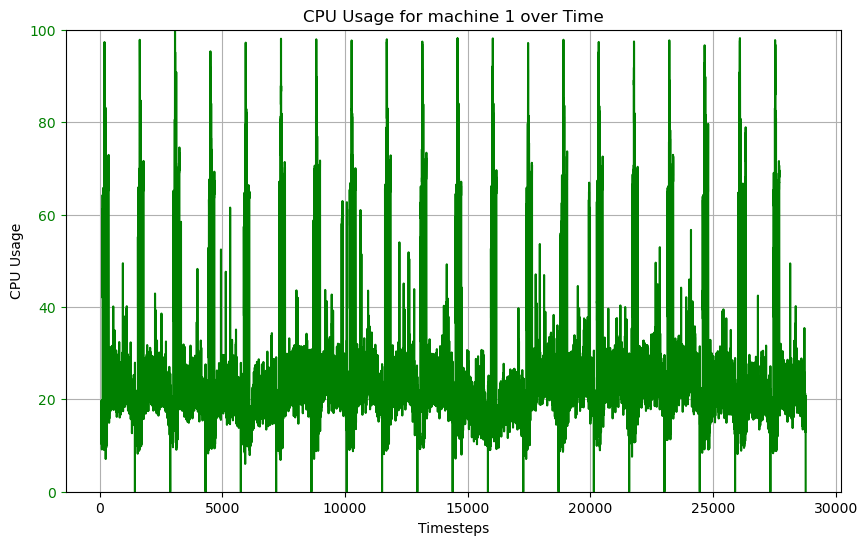

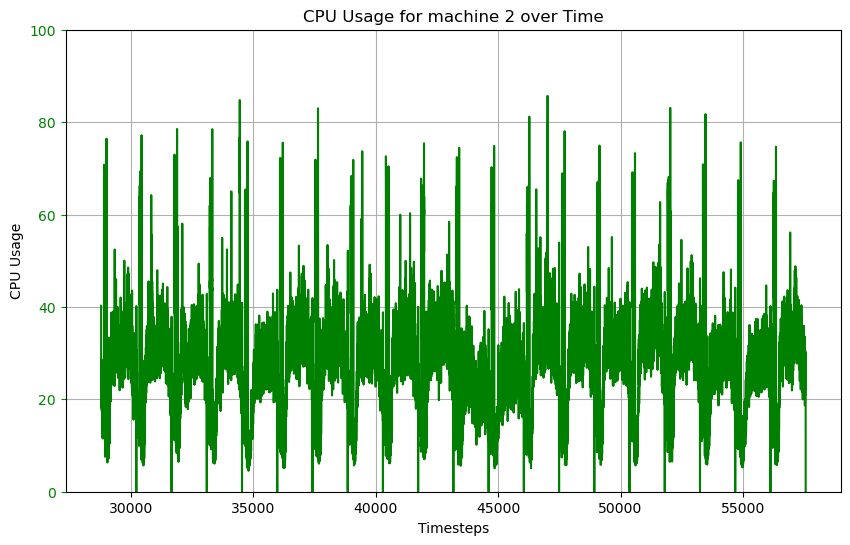

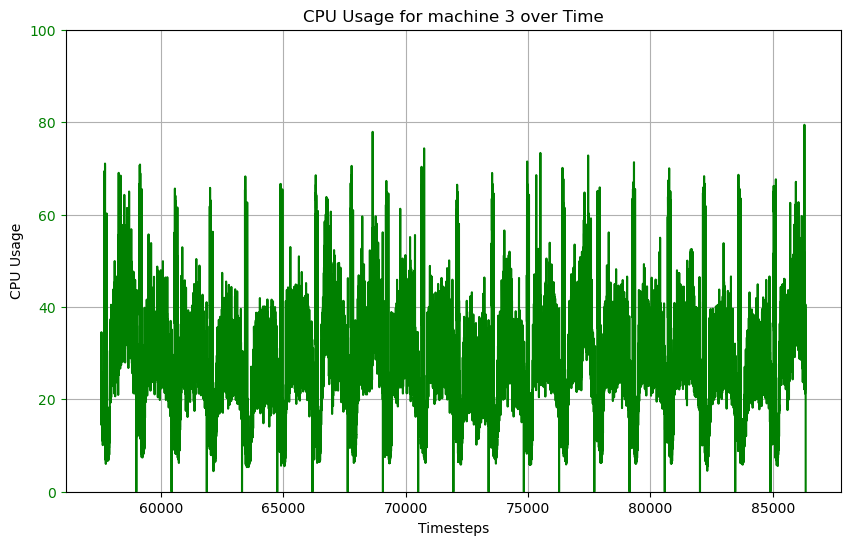

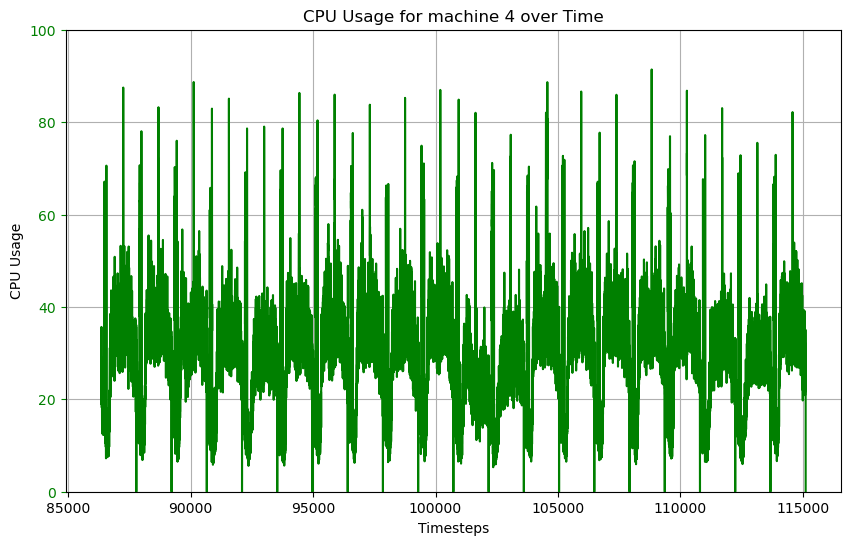

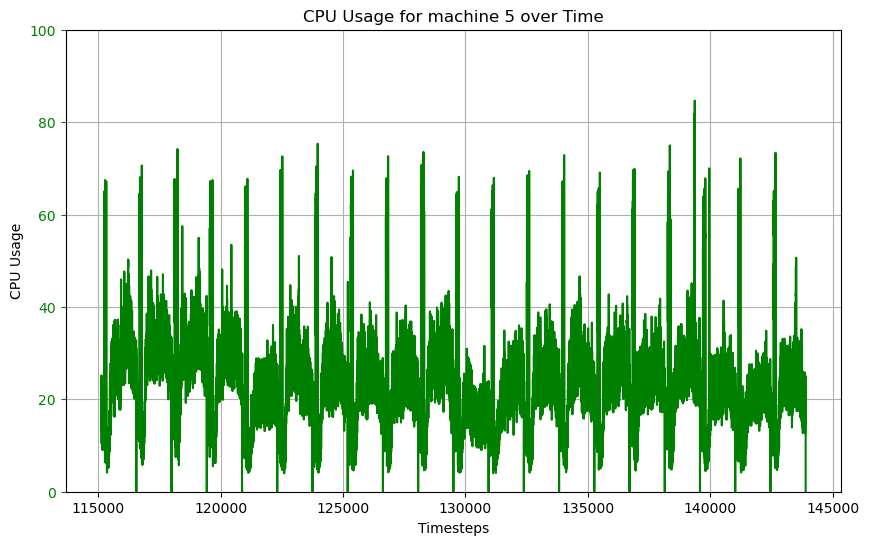

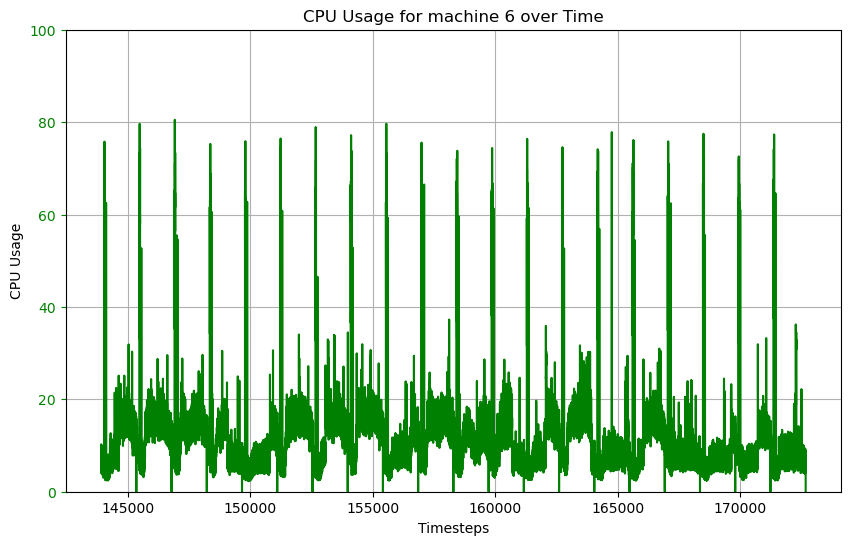

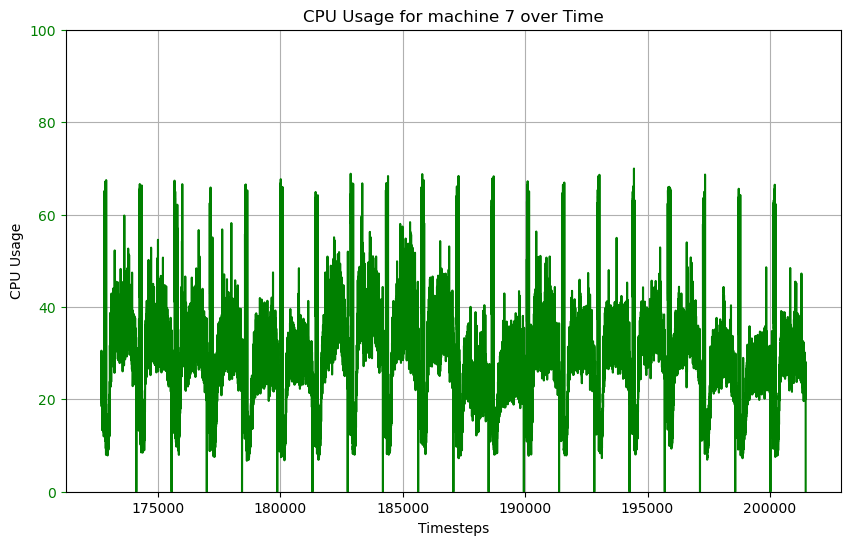

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

# Define a function to create lagged features
def create_additional_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    df['cpu_change'] = df['cpu_usage'].diff() # Change in CPU usage
    df['moving_avg'] = df['cpu_usage'].rolling(window=10).mean() # 10-minute moving average
    return df

cpu_data = pd.read_csv('../Utilities\csv/trainingset.csv')
cpu_data['machine_id'] = pd.Categorical(cpu_data['machine_id']).codes + 1
cpu_data = create_time_features(cpu_data)
lags = [5, 10, 60]
cpu_data = create_additional_features(cpu_data, 'cpu_usage', lags)

# Drop any rows with NaN values that were created due to shifting
cpu_data.dropna(inplace=True)

all_features_no_timestamp = cpu_data.columns[1:len(cpu_data.columns)]
# Extract the relevant features from your dataset for the HMM
features_for_hmm = cpu_data[all_features_no_timestamp].values

# Define and fit the HMM model
num_states = 2  # You can adjust this based on the nature of the data
model = hmm.GaussianHMM(n_components=num_states, covariance_type="full", n_iter=1000)

# Fit the HMM model to the features
model.fit(features_for_hmm)

# Predict hidden states for each time step
hidden_states = model.predict(features_for_hmm)

cpu_data['hidden_state'] = hidden_states

cpu_data.head

file_path = "../Utilities/csv/cpu_usage_train.csv"
cpu_data.to_csv(file_path, index=False)

for machine_id, machine_data in cpu_data.groupby('machine_id'):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(machine_data['cpu_usage'], 'g-', label='CPU Usage')
    ax.tick_params('y', colors='g')
    plt.xlabel('Timesteps')
    plt.ylabel('CPU Usage')
    ax.set_ylim(0, 100)
    plt.title(f'CPU Usage for machine {machine_id} over Time')
    plt.grid(True)
    plt.show()

# Generate Replicas

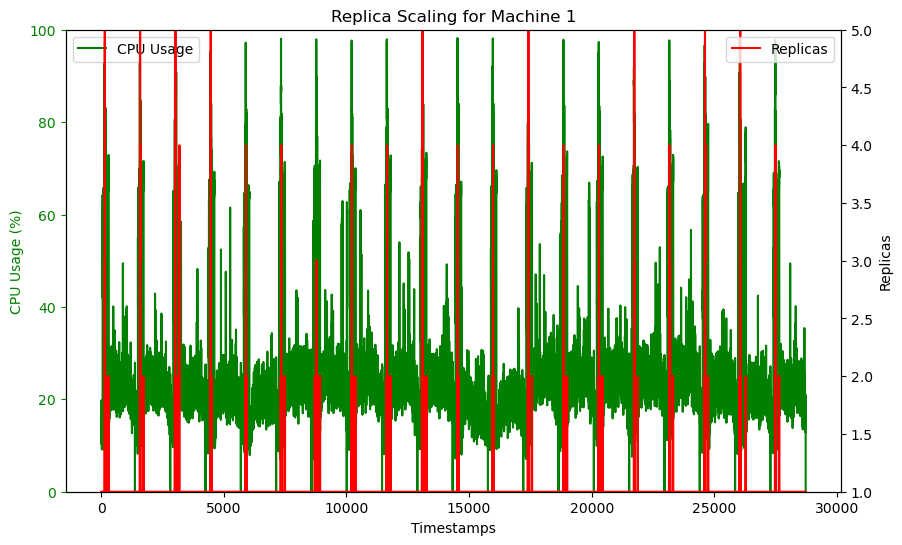

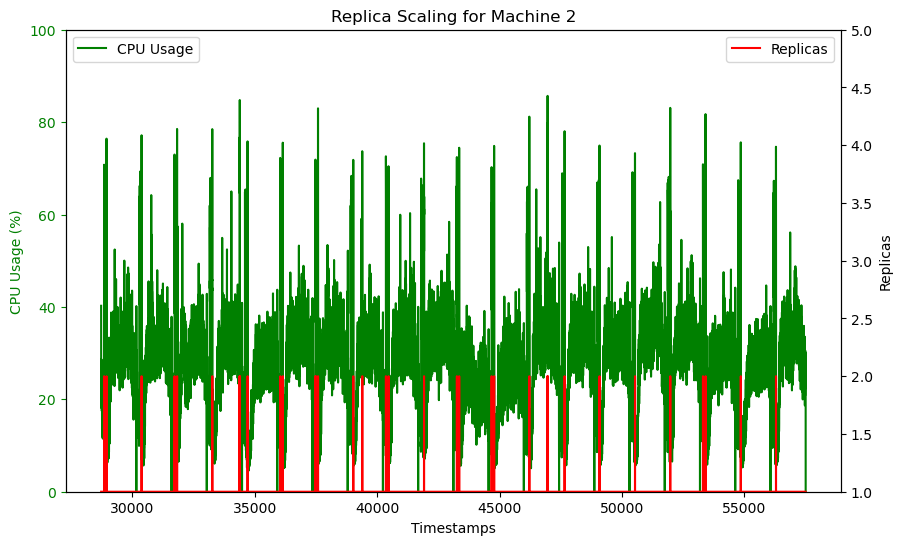

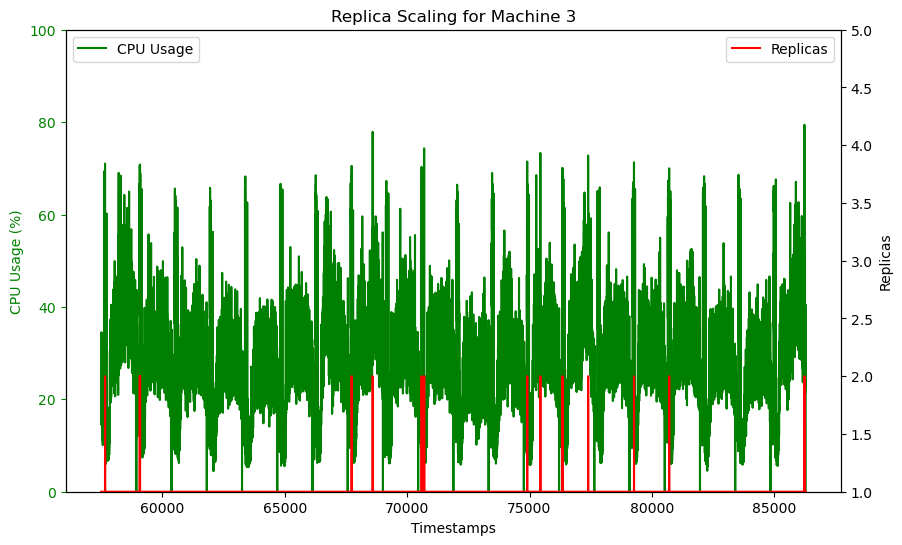

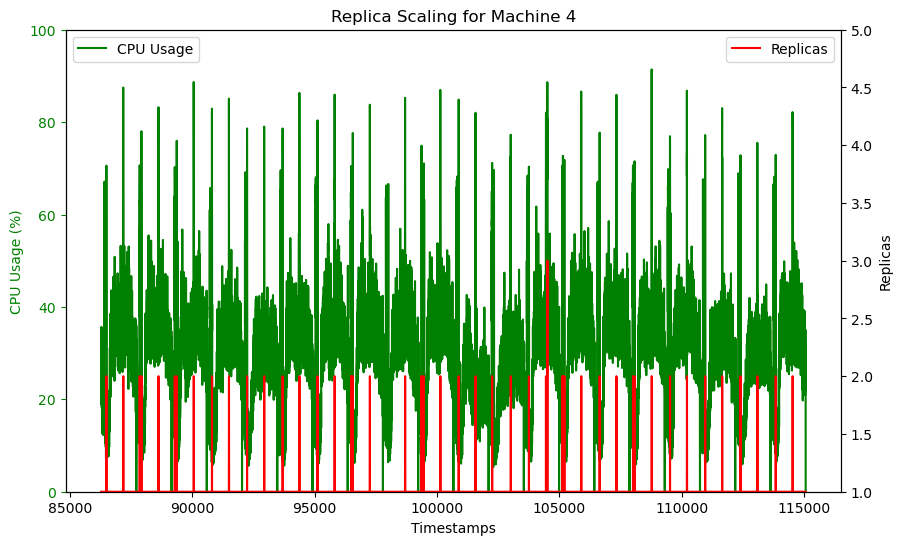

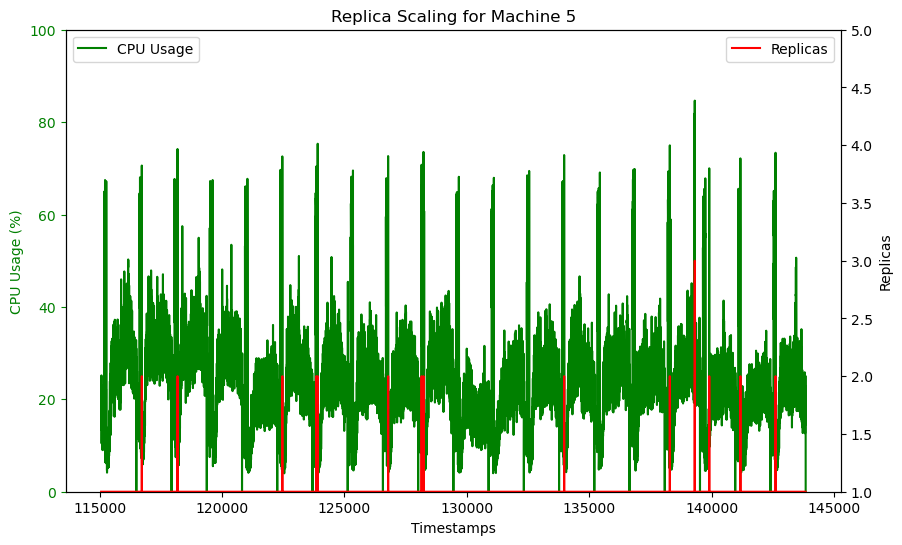

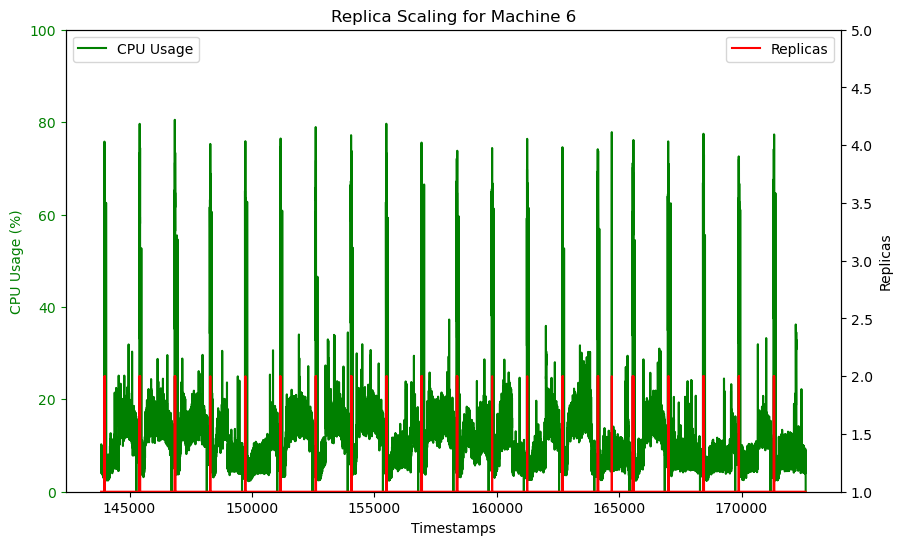

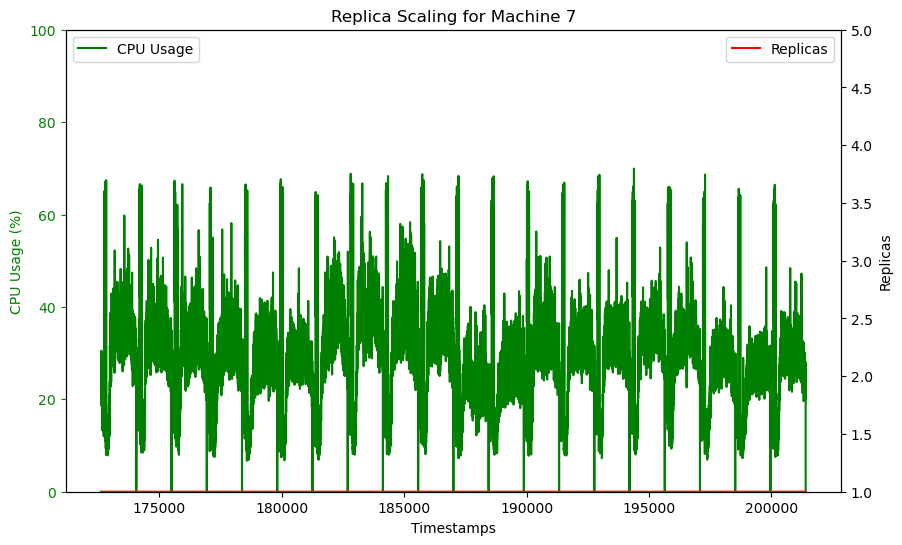

In [12]:
# Variables for tracking cooldown periods and consecutive low CPU usage
scale_up_cooldown = 5  # No scale-up allowed for 5 timesteps after the last scale-up
scale_down_consecutive = 2  # CPU must be below threshold for 2 consecutive timesteps to scale down

initial_replicas = 1
threshold = 70  # SLA threshold at 70%

# Function to generate replicas for each machine separately
def generate_replicas_for_machine(machine_data):
    time_since_last_scale_up = scale_up_cooldown  # Initialize at cooldown to allow immediate scaling if needed
    consecutive_below_threshold = 0  # Track consecutive timesteps below threshold
    current_replicas = initial_replicas  # Start with initial number of replicas

    replicas = []  # List to store the replicas for this machine

    # Iterate through CPU usage data for this machine
    for cpu_usage in machine_data['cpu_usage']:
        # Check if scaling up is allowed
        if cpu_usage >= threshold:
            if time_since_last_scale_up >= scale_up_cooldown:
                current_replicas += 1  # Scale up
                time_since_last_scale_up = 0  # Reset cooldown
            else:
                time_since_last_scale_up += 1  # Increment cooldown timer
            consecutive_below_threshold = 0  # Reset consecutive below counter

        # Check for scaling down
        else:
            consecutive_below_threshold += 1
            if consecutive_below_threshold >= scale_down_consecutive and current_replicas > 1:
                current_replicas -= 1  # Scale down
                consecutive_below_threshold = 0  # Reset consecutive counter
            time_since_last_scale_up += 1  # Continue cooldown for scale up

        # Append the current number of replicas to the list
        replicas.append(current_replicas)

    # Add the 'replicas' column to the machine data
    machine_data['replicas'] = replicas
    return machine_data

# Group by 'machine_id' and apply the replica generation function to each group
cpu_data_with_replicas = cpu_data.groupby('machine_id', group_keys=False).apply(generate_replicas_for_machine)

# Reset the index after applying groupby
cpu_data_with_replicas.reset_index(drop=True, inplace=True)

# Plot replicas and CPU usage for each machine
for machine_id, machine_data in cpu_data_with_replicas.groupby('machine_id', group_keys=False):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(machine_data['cpu_usage'], 'g-', label='CPU Usage')
    ax1.set_xlabel('Timestamps')
    ax1.set_ylabel('CPU Usage (%)', color='g')
    ax1.tick_params('y', colors='g')
    ax1.set_ylim(0, 100)
    
    ax2 = ax1.twinx()
    ax2.plot(machine_data['replicas'], 'r-', label='Replicas')
    ax2.set_ylabel('Replicas')
    ax2.tick_params('y')
    ax2.set_ylim(1, 5)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f'Replica Scaling for Machine {machine_id}')
    plt.show()

# Save the dataset with replicas to a CSV file
file_path = "../Utilities/csv/cpu_replicas.csv"
cpu_data_with_replicas.to_csv(file_path, index=False)

# Predict Workload

In [13]:
# Load your data
cpu_data = pd.read_csv('../Utilities/csv/cpu_usage_train.csv')

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Window size (e.g., past 60 time steps) and prediction horizon (next 10 timesteps)
window_size = 60
prediction_horizon = 10

# Function to generate LSTM sequences
def create_lstm_sequences(group_data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        # Features are all columns except 'datetime', 'cpu_usage', and 'machine_id'
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values)
        # Target is the next 10 CPU usage values
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values)
    return np.array(X), np.array(y)

all_features_no_timestamp_cpu_usage = cpu_data.columns[2:len(cpu_data.columns)]
# Scale features and target (fit on the entire dataset)
cpu_data[all_features_no_timestamp_cpu_usage] = feature_scaler.fit_transform(cpu_data[all_features_no_timestamp_cpu_usage])
cpu_data[["cpu_usage"]] = target_scaler.fit_transform(cpu_data[["cpu_usage"]])

# Train/test split ratios
train_ratio = 0.8

# Lists to store train/test data
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []

# Group by machine_id
for machine_id, group_data in cpu_data.groupby('machine_id'):
    # Split the data into train and test sets for this machine
    train_data, test_data = train_test_split(group_data, test_size=1 - train_ratio, shuffle=False)
    
    # Generate moving windows for the training set
    X_train, y_train = create_lstm_sequences(train_data, window_size, prediction_horizon)
    X_train_all.append(X_train)
    y_train_all.append(y_train)
    
    # Generate moving windows for the test set
    X_test, y_test = create_lstm_sequences(test_data, window_size, prediction_horizon)
    X_test_all.append(X_test)
    y_test_all.append(y_test)

# Combine all the machine-specific windows together for training and testing
X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)
X_test_all = np.concatenate(X_test_all, axis=0)
y_test_all = np.concatenate(y_test_all, axis=0)

# Print the shapes of the final train/test data
print("Train shapes:", X_train_all.shape, y_train_all.shape)
print("Test shapes:", X_test_all.shape, y_test_all.shape)

# Build the enhanced CNN-LSTM model
lstm_model = Sequential()
# CNN layers
lstm_model.add(Conv1D(filters=240, kernel_size=3, activation='relu', input_shape=(X_train_all.shape[1], X_train_all.shape[2])))
lstm_model.add(BatchNormalization())  # Normalize activations
lstm_model.add(Conv1D(filters=120, kernel_size=3, activation='relu'))
lstm_model.add(BatchNormalization())  # Normalize activations
lstm_model.add(MaxPooling1D(pool_size=2))
# LSTM layers
lstm_model.add(LSTM(units=250, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(units=50, return_sequences=False))
# Output layer (multi-step prediction)
lstm_model.add(Dense(prediction_horizon))

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_test.hdf5', monitor='val_loss', save_best_only=True, mode='min')
# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
lstm_model.compile(optimizer="adam", loss='huber_loss')  # Use Huber loss to reduce outliers' impact
lstm_model.summary()
# Train the model
history = lstm_model.fit(X_train_all, y_train_all, epochs=50, batch_size=64, validation_data=(X_test_all, y_test_all),
                         verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr])

mse_lstm = lstm_model.evaluate(X_test_all, y_test_all)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

Train shapes: (160637, 60, 11) (160637, 10)
Test shapes: (39797, 60, 11) (39797, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 58, 240)           8160      
                                                                 
 batch_normalization_6 (Bat  (None, 58, 240)           960       
 chNormalization)                                                
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 120)           86520     
                                                                 
 batch_normalization_7 (Bat  (None, 56, 120)           480       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 28, 120)           0         
 g1D)                              

c:\Users\brand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2510/2510 [==============================] - 934s 366ms/step - loss: 0.0027 - val_loss: 0.0023 - lr: 0.0010
Epoch 2/50
2510/2510 [==============================] - 1035s 413ms/step - loss: 0.0019 - val_loss: 0.0017 - lr: 0.0010
Epoch 3/50
2510/2510 [==============================] - 1098s 437ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0010
Epoch 4/50
2510/2510 [==============================] - 1022s 407ms/step - loss: 0.0016 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/50
2510/2510 [==============================] - 984s 392ms/step - loss: 0.0015 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/50
2510/2510 [==============================] - 1072s 427ms/step - loss: 0.0013 - val_loss: 0.0015 - lr: 5.0000e-04
Epoch 7/50
2510/2510 [==============================] - 949s 378ms/step - loss: 0.0012 - val_loss: 0.0015 - lr: 5.0000e-04
Epoch 8/50
2510/2510 [==============================] - 908s 362ms/step - loss: 0.0012 - val_loss: 0.0015 - lr: 5.0000e-04
Epoch 9/50
2510/2510 [=====================

# Forecast prediction

178/178 [==============================] - 33s 182ms/step
RMSE: 0.020914448787650176, MSE: 0.0004374141680912419


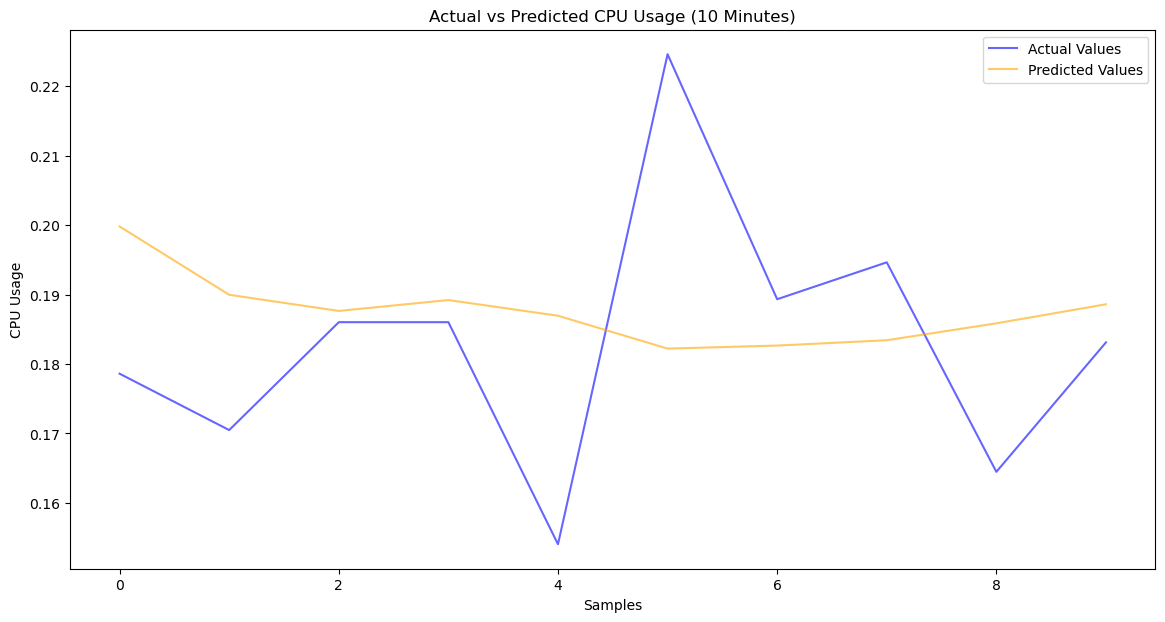

RMSE: 0.04535266419680496, MSE: 0.0020568641497481547


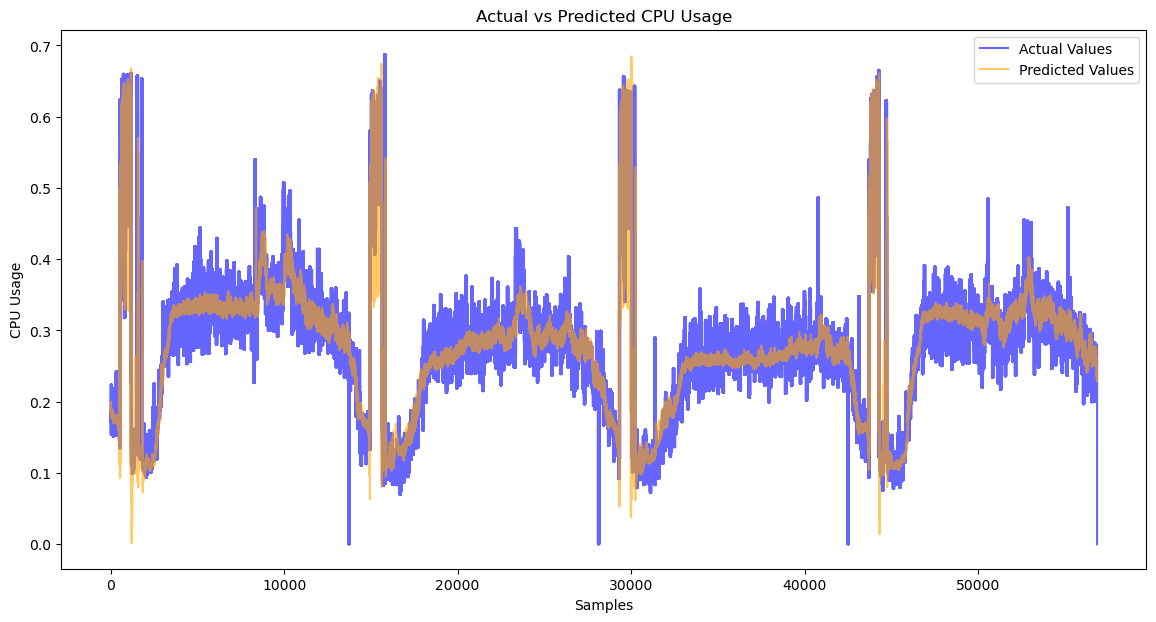

In [17]:
# Make predictions
y_pred = lstm_model.predict(X_test)

# Inverse transform the predictions using the target scaler
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

# If `y_test` also needs inverse transforming
y_test_unscaled = target_scaler.inverse_transform(y_test)


# Calculate MSE and RMSE
mse_lstm = mean_squared_error(y_test_unscaled[0], y_pred_unscaled[0])
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

# Plotting Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled[0], label='Actual Values', color='blue', alpha=0.6)
plt.plot(y_pred_unscaled[0], label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage (10 Minutes)')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

mse_lstm = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")
# Plotting Actual vs Predicted values
y_test_rescaled_flat = y_test_unscaled.flatten()
predictions_rescaled_flat = y_pred_unscaled.flatten()
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()
# BEST MODEL (best_model.hdf5): RMSE: 1.874064941651963, MSE: 3.5121194055289755
# ADDED: Made HMM use all datapoints to predict, num states = 2

# Predicting number of replicas

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mean Squared Error (MSE): 0.008174509120719514


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


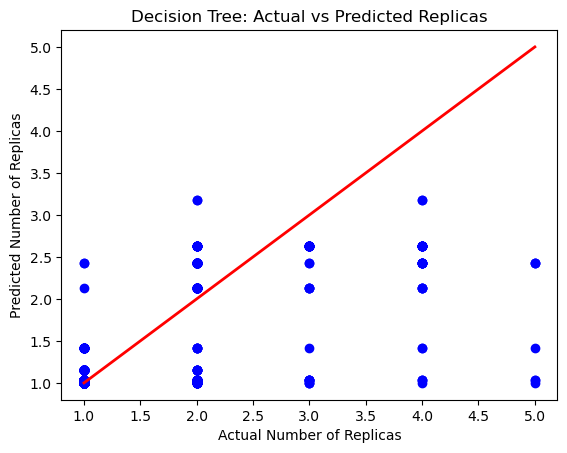

178/178 [==============================] - 13s 71ms/step
Predicted number of replicas for 10 mins future CPU usage (0.1885938048362732): 1.0011182555213867


In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

replicas_data = pd.read_csv('../Utilities\csv/cpu_replicas.csv')

# Split the data
X = replicas_data[['cpu_usage']]
y = replicas_data['replicas']
X_train_replicas, X_test_replicas, y_train_replicas, y_test_replicas = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for decision tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the model
tree_model = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_replicas.values, y_train_replicas.values)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Predict with the best model
best_model = grid_search.best_estimator_
y_pred_replicas = best_model.predict(X_test_replicas)

# Evaluate the model
mse = mean_squared_error(y_test_replicas, y_pred_replicas)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the results
plt.scatter(y_test_replicas, y_pred_replicas, color='blue')
plt.plot([y_test_replicas.min(), y_test_replicas.max()], [y_test_replicas.min(), y_test_replicas.max()], color='red', lw=2)
plt.xlabel('Actual Number of Replicas')
plt.ylabel('Predicted Number of Replicas')
plt.title('Decision Tree: Actual vs Predicted Replicas')
plt.show()

# Predict using LSTM output
predictions = lstm_model.predict(X_test)
# cpu_usage_scaler = MinMaxScaler()
# cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

predictions_rescaled = target_scaler.inverse_transform(predictions)

future_replicas = best_model.predict(predictions_rescaled.reshape(-1, 1))
print(f'Predicted number of replicas for 10 mins future CPU usage ({predictions_rescaled[0][-1]}): {future_replicas[0]}')

# Detect Burst

In [16]:
import time
from kubernetes import client, config
import requests
import json
from datetime import datetime, timedelta

def get_time_range():
    end_time = int(time.time())  # Current timestamp in seconds
    start_time = end_time - (3 * 3600) # Hours in seconds
    return start_time, end_time

# Prometheus server URL (adjust according to your setup)
PROMETHEUS_URL = "http://localhost:9090"

def query_prometheus_range(query, start_time, end_time, step):
    params = {
        'query': query,
        'start': start_time,
        'end': end_time,
        'step': step  # Interval between points (e.g., 60s = 1 minute intervals)
    }
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query_range", params=params)
    return response.json()

# Function to get CPU usage for a pod over the past hour
def get_pod_cpu_usage_range(pod_name, start_time, end_time):
    # Prometheus query to get CPU usage over the last hour (rate over 1 minute)
    query = f'avg((sum(rate(container_cpu_usage_seconds_total{{pod=~"{pod_name}-.*"}}[1m])) by (pod)) / (sum(kube_pod_container_resource_limits{{pod=~"{pod_name}-.*", resource="cpu"}}) by (pod))) * 100'

    # Query Prometheus with a 60-second step interval
    result = query_prometheus_range(query, start_time, end_time, step="60")

    return result

# Function to convert the Prometheus result to a pandas DataFrame
def prometheus_to_dataframe(prometheus_result):
    if not prometheus_result or 'data' not in prometheus_result:
        return pd.DataFrame()  # Return an empty DataFrame if there's no data

    # Extract the 'values' from the first result (assuming only one pod)
    values = prometheus_result['data']['result'][0]['values']

    # Create a DataFrame from the values
    df = pd.DataFrame(values, columns=['timestamp', 'value'])

    # Convert UNIX timestamp to human-readable datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    # Convert the value column to float
    df['value'] = df['value'].astype(float)

    return df

# Get weather data
def get_weather_data(start_time, end_time):
    API_KEY = 'DbiSeuEozdnpBiOOJ25UH66tyRj17LDx'
    LOCATION = "51.507407,-0.12772404"  # London

    start_time = datetime.utcfromtimestamp(start_time).isoformat() + "Z"
    end_time = datetime.utcfromtimestamp(end_time).isoformat() + "Z"

    # Build the API URL for the Timeline API
    URL = f"https://api.tomorrow.io/v4/timelines?apikey={API_KEY}"

    # Define the query parameters
    query_params = {
        "location": LOCATION,
        "fields": ["temperature", "humidity", "windSpeed"],
        "units": "metric",  # For Celsius and kph
        "timesteps": "1m",  # 1-minute intervals
        "startTime": start_time,
        "endTime": end_time,
    }

    # Make the API request
    response = requests.get(URL, params=query_params)
    data = response.json()
    # Check for a successful response
    if response.status_code == 200:
        # Create a list to store the data
        weather_data = []
        
        # Loop through each interval and extract the weather data
        for interval in data["data"]["timelines"][0]["intervals"]:
            datetime_obj = datetime.strptime(interval["startTime"], '%Y-%m-%dT%H:%M:%SZ')
            formatted_timestamp = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')
            weather_record = {
                "time": formatted_timestamp,
                "temperature": interval["values"]["temperature"],
                "humidity": interval["values"]["humidity"],
                "wind_speed": interval["values"]["windSpeed"],
            }
            weather_data.append(weather_record)
        
        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(weather_data)
    else:
        print(f"Error: {response.status_code}, {data['message']}")
    return df

    API_KEY = 'DbiSeuEozdnpBiOOJ25UH66tyRj17LDx'
    LOCATION = "51.507407,-0.12772404"  # London

    start_time = datetime.utcfromtimestamp(start_time).isoformat() + "Z"
    end_time = datetime.utcfromtimestamp(end_time).isoformat() + "Z"

    # Build the API URL for the Timeline API
    URL = f"https://api.tomorrow.io/v4/timelines?apikey={API_KEY}"

    # Define the query parameters
    query_params = {
        "location": LOCATION,
        "fields": ["temperature", "humidity", "windSpeed"],
        "units": "metric",  # For Celsius and kph
        "timesteps": "1m",  # 1-minute intervals
        "startTime": start_time,
        "endTime": end_time,
    }

    # Make the API request
    response = requests.get(URL, params=query_params)
    data = response.json()
    # Check for a successful response
    if response.status_code == 200:
        # Create a list to store the data
        weather_data = []
        
        # Loop through each interval and extract the weather data
        for interval in data["data"]["timelines"][0]["intervals"]:
            datetime_obj = datetime.strptime(interval["startTime"], '%Y-%m-%dT%H:%M:%SZ')
            formatted_timestamp = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')
            weather_record = {
                "time": formatted_timestamp,
                "temperature": interval["values"]["temperature"],
                "humidity": interval["values"]["humidity"],
                "wind_speed": interval["values"]["windSpeed"],
            }
            weather_data.append(weather_record)
        
        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(weather_data)
    else:
        print(f"Error: {response.status_code}, {data['message']}")
    return df

def get_dataset():
    start_time, end_time = get_time_range()
    weather_data_1h = get_weather_data(start_time, end_time)
    pod_cpu_data = get_pod_cpu_usage_range("microsvc", start_time, end_time)

    # Convert the data to a pandas DataFrame
    cluster_data_1h = prometheus_to_dataframe(pod_cpu_data)

    cluster_data_1h['timestamp'] = pd.to_datetime(cluster_data_1h['timestamp']).dt.floor('T')
    weather_data_1h['time'] = pd.to_datetime(weather_data_1h['time']).dt.floor('T')
    full_1h_data = pd.merge(cluster_data_1h, weather_data_1h, left_on='timestamp', right_on='time')
    full_1h_data = full_1h_data.drop('time', axis=1)
    full_1h_data = full_1h_data.drop('timestamp', axis=1)
    full_1h_data.loc[:, 'temperature_lag_10_mins'] = full_1h_data['temperature'].shift(10)
    full_1h_data.loc[:, 'temperature_lag_1_hour'] = full_1h_data['temperature'].shift(60)
    full_1h_data.dropna(inplace=True)
    return full_1h_data

def create_sequences_multi_step(data, seq_length, pred_steps):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequences.append(data[i:i + seq_length, :-1])  # Features (last hour of data)
        labels.append(data[i + seq_length:i + seq_length + pred_steps, -1])  # Predict next 10 values
    return np.array(sequences), np.array(labels)

# Load kube config
config.load_kube_config()
# If running inside the cluster, use:
# config.load_incluster_config()

def scale_out(additional_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = current_replicas + additional_replicas
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled out to {new_replicas} replicas.")
    return new_replicas

def scale_in(remove_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = max(current_replicas - remove_replicas, 1)
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled in to {new_replicas} replicas.")
    return new_replicas

def detect_burst(monitoring_interval, window_size, resource_prediction_model, replica_prediction_model, replicas):
    is_burst = False
    replicas_before_burst = 1
    past_predictions = np.array([])
    feature_scaler_burst = MinMaxScaler()
    # while True:
    x = 0
    while x < 5:
        x += 1
        time.sleep(monitoring_interval)
        full_3h_data = get_dataset()
        scaled_data = feature_scaler_burst.fit_transform(full_3h_data)
        # In 10 minute increments
        prediction_steps = 10
        prediction_lookup = 60
        predict_data, predict_labels = create_sequences_multi_step(scaled_data, prediction_lookup, prediction_steps)
        cpu_predictions = resource_prediction_model.predict(predict_data)
        predictions_rescaled = feature_scaler_burst.inverse_transform(cpu_predictions)
        n_predicted = replica_prediction_model.predict(predictions_rescaled.reshape(-1, 1))
        past_predictions = np.append(past_predictions, n_predicted)
        sd_max = 0
        n_max = 0
        for i in range(1, window_size + 1):
            sigma_i = np.std(past_predictions)

            if sigma_i > sd_max:
                sd_max = sigma_i
                n_max = max(past_predictions.flatten())

        if sd_max >= 2 and not is_burst:
            # Detected burst, increase replicas to n_max
            replicas_during_burst = n_max
            is_burst = True
            replicas_before_burst = n_predicted  # Store current predicted replicas before burst
        elif sd_max >= 2 and is_burst:
            # Continuation of the burst
            replicas_during_burst = n_max
        elif sd_max < 2 and is_burst:
            if replicas_before_burst > n_predicted:
                # Burst ending, scale back to predicted replicas
                replicas_during_burst = n_predicted
                is_burst = False
                replicas_before_burst = 1
            else:
                # Keep scaling at n_max
                replicas_during_burst = n_max
        else:
            # Normal condition, set replicas to predicted
            replicas_during_burst = n_predicted[0]

        current_replica_count = int(replicas)
        replicas_during_burst = int(replicas_during_burst)

        if current_replica_count < replicas_during_burst:
            additional_replicas = int(replicas_during_burst - current_replica_count)
            replicas = scale_out(additional_replicas, 'microsvc', namespace='default')
        elif current_replica_count > replicas_during_burst:
            replica_difference = int(current_replica_count - replicas_during_burst)
            replicas = scale_in(replica_difference, 'microsvc', namespace='default')
        else:
            print("No replica update needed")
        # Log the updated replica count
        print(f"Updated replica count: {replicas}")


api = client.AppsV1Api()
deployment = api.read_namespaced_deployment('microsvc', namespace='default')
replicas = deployment.spec.replicas
print(f"Original replica count: {replicas}")
detect_burst(60, 10, lstm_model, best_model, replicas)

Original replica count: 1


ConnectionError: HTTPConnectionPool(host='localhost', port=9090): Max retries exceeded with url: /api/v1/query_range?query=avg%28%28sum%28rate%28container_cpu_usage_seconds_total%7Bpod%3D~%22microsvc-.%2A%22%7D%5B1m%5D%29%29+by+%28pod%29%29+%2F+%28sum%28kube_pod_container_resource_limits%7Bpod%3D~%22microsvc-.%2A%22%2C+resource%3D%22cpu%22%7D%29+by+%28pod%29%29%29+%2A+100&start=1729079050&end=1729089850&step=60 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000247E21D85D0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

# Create HPA System

In [ ]:
# import joblib

# joblib.dump(model, 'cpu_usage_predictor.pkl')
# joblib.dump(best_model, 'replicas_predictor.pkl')
